In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from neurorient import NeurOrient

from neurorient.utils_model import get_radial_profile

In [2]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

spi_data = torch.load(
    f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor}_poisson{poisson}_num{num_images//1000}K.pt')
model_dir = '/pscratch/sd/z/zhantao/neurorient_repo/model'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [3]:
q_values, radial_profile = get_radial_profile(
    spi_data['intensities'][:1000], 
    spi_data['pixel_position_reciprocal'])

In [4]:
radial_scale_configs = {
    "q_values": q_values,
    "radial_profile": radial_profile,
    "alpha": 1.0
}

In [5]:
model = NeurOrient(
    spi_data['pixel_position_reciprocal'], path=model_dir, 
    radial_scale_configs=radial_scale_configs, lr=1e-3,
    photons_per_pulse=1e12 * increase_factor)

In [6]:
import lightning as L

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [8]:
dataset = TensorDataset(spi_data['intensities'].unsqueeze(1))

train_idx, val_test_idx = train_test_split(np.arange(len(dataset)), test_size=1/10, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=1/2, random_state=42)

train_dataloader = DataLoader([dataset[i] for i in train_idx], batch_size=10, shuffle=True)
val_dataloader = DataLoader([dataset[i] for i in val_idx], batch_size=10, shuffle=False)

In [9]:
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar

checkpoint_callback = ModelCheckpoint(
    every_n_train_steps=10, save_last=True, save_top_k=1, monitor="val_loss",
    filename=f'{pdb}-{{epoch}}-{{step}}'
)

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-p ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/pscratch/sd/z/zhantao/conda/om/

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   1%|          | 10/900 [00:01<01:54,  7.75it/s, v_num=1.56e+7]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)


Epoch 6:  60%|██████    | 540/900 [01:18<00:52,  6.89it/s, v_num=1.56e+7]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


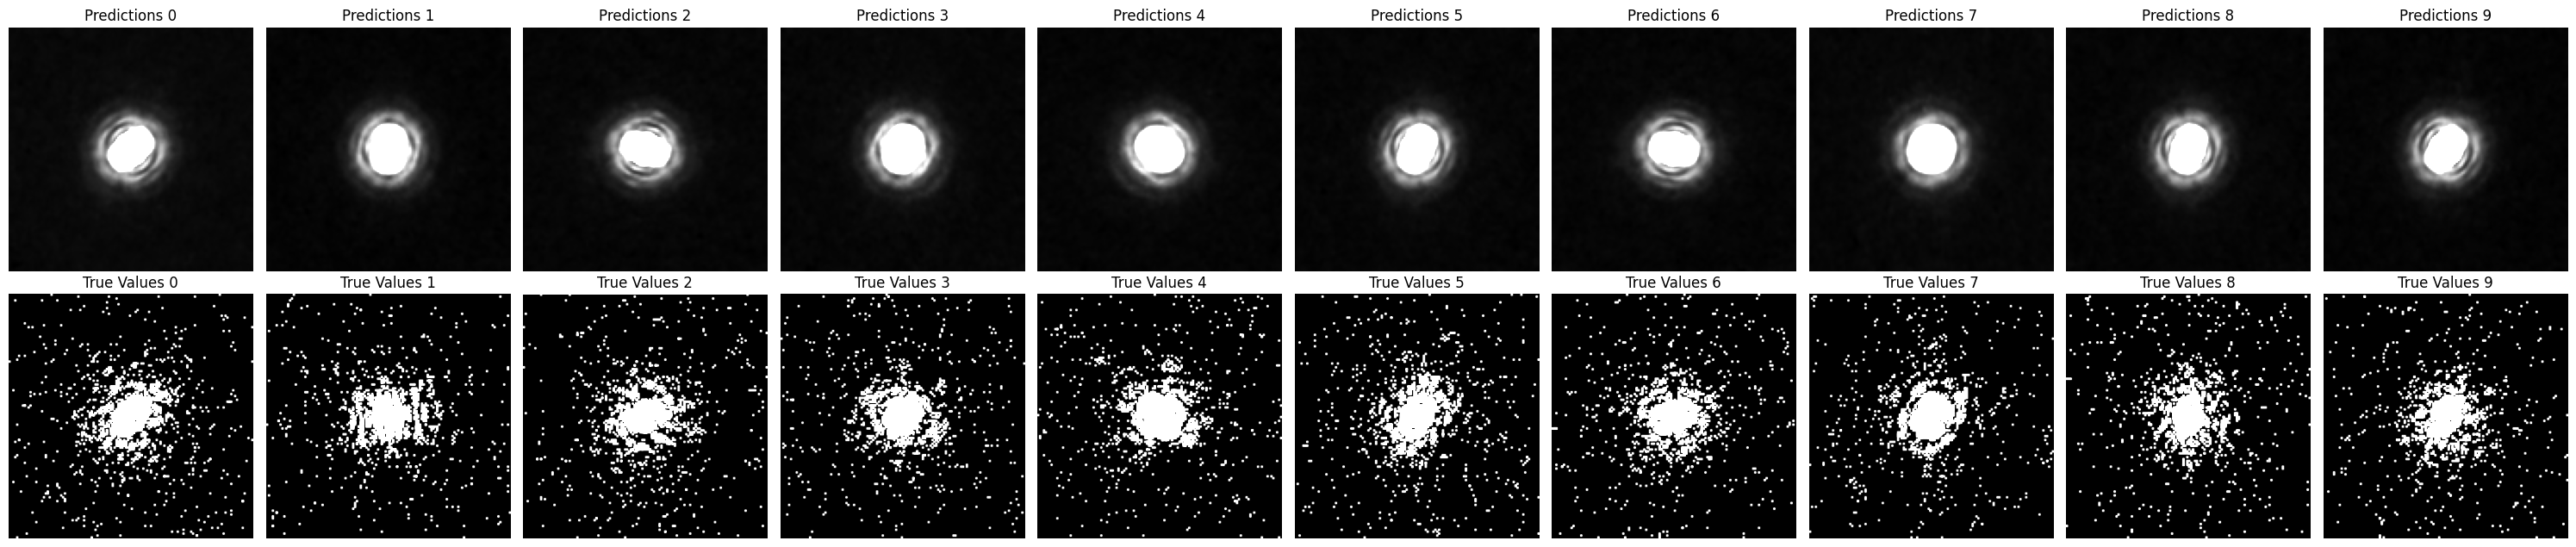

In [10]:
torch.set_float32_matmul_precision('high')
trainer = L.Trainer(
    max_epochs=1000, accelerator='gpu',
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=10)],
    log_every_n_steps=1, devices=torch.cuda.device_count(),
    enable_checkpointing=True, default_root_dir=model.path)
trainer.fit(model, train_dataloader, val_dataloader)